# <font color="#4B0082"> Classification of *Iris* species based on petal versus sepal measurements.
<img src="https://i.gifer.com/OpHc.gif" width = "600"/>

 ### Introduction:   
*Iris* is a plant within the family *Iridacae* found in the temperate Northern Hemisphere, usually in Europe and Asia. (Akbar, 2020) The *Iris* flower is bright purple with three thin petals and three longer sepals under the petals. The plant is used to treat small ailments such as sores, burns, itching, coughs, inflammations, and pneumonia. (Diksha et al., 2022) Studies continue on the use of *Iris*, as scientists believe that the plant can be used to treat oxidative-stress-related diseases like cancer, diabetes, and cardiovascular disease. (Sohaib et al., 2022) Correctly identifying *Iris* species is important when using the plant for medicinal purposes. _________ (add research here about if petal or sepal is a better predictor ; if different species have different sepal or petal length) We want to see if we can correctly predict the species of *Iris* based on petal and sepal measurements and determine which is a better predictor. The dataset we have chosen is “Iris” from Fisher (1988) found on the UCI Machine Learning Repository. The possible *Iris* species classifications within this data set are *Iris setosa*, *Iris versicolour*, and *Iris virginica*.

 ### Methods & Results
The goal of our project is to determine what group of factors have the most influence on the prediction of *Iris* species between the 3 types of *Iris variegata*, *Iris Setosa*, and *Iris Versicolor*. Since this is a predictive question, we will be using classification with K-nearest neighbors algorithm.

First, we load the necessary packages into R, including the `“kknn”` package required for the classification process. We also set our seed to `1382` for result reproducibility.

In [1]:
# KM - Run cell before starting workspace - loads necessary packages
library(tidyverse)
library(repr)
library(tidymodels)
library(tibble)
options(repr.matrix.max.rows = 6)
install.packages("kknn")
set.seed(1382)  # Set your desired seed for reproducibility

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

We read the data set into R using the `read_csv` function since the data set uses comma delimited values. The original dataset did not have any names describing each column, so we renamed the columns by referring to the data descriptions on the website. Then we printed the data set to see what it looks like.

In [2]:
iris_data <- read_csv ("data/iris.data")
iris_data

Rows: 149 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Iris-setosa
dbl (4): 5.1, 3.5, 1.4, 0.2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


5.1,3.5,1.4,0.2,Iris-setosa
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,Iris-setosa
⋮,⋮,⋮,⋮,⋮
6.5,3.0,5.2,2.0,Iris-virginica
6.2,3.4,5.4,2.3,Iris-virginica
5.9,3.0,5.1,1.8,Iris-virginica


##### <font color="#4B0082"> Table.1: Raw Dataset

After importing the dataset from the provided link, we observed that the columns lacked descriptive names, making it challenging to interpret the data effectively. In response, we added a step in our data wrangling and cleaning process to assign names to each column based on the information available on the source website, using the `setNames` function.

Simultaneously, we noted that the rows were originally organized based on species, where all rows corresponding to one species were grouped together, followed by rows of the second species, and so on. However, this type of organization can introduce bias when splitting the data for training and testing purposes. To address this concern, we randomized the order of the rows using the `slice` function. By doing so, we ensure that our subsequent data split into training and testing sets will be unbiased, with a balanced representation of all three species. This comprehensive approach to data preparation, including renaming columns and randomizing rows, sets the foundation for more robust analyses of the Iris dataset.

Furthermore, we noticed that the 'class' column contained values with the `Iris-` prefix (e.g., `Iris-versicolor`, `Iris-setosa`). To ensure clarity in our data, we decided to remove the `Iris-` prefix for the observations in this column using the mutate function from the dplyr package, combined with the gsub function. The gsub function allowed us to globally substitute the 'Iris_' prefix with an empty string, leaving only the species name in the 'class' column.

Since we are predicting species, we mutated the data set with `as_factor` function so that `class` is treated as a factor for future classifications.

We named the final data set `iris_clean`.

In [3]:
iris_clean <- iris_data |>
    setNames(c("sepal_length", "sepal_width", "petal_length", "petal_width", "class"))|>
    slice(sample(n()))  |>
    mutate(class = gsub("Iris-", "", class)) |>
    mutate (class= as_factor (class))
iris_clean

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6.4,2.8,5.6,2.2,virginica
6.1,2.8,4.7,1.2,versicolor
5.7,3.0,4.2,1.2,versicolor
⋮,⋮,⋮,⋮,⋮
4.7,3.2,1.6,0.2,setosa
5.8,4.0,1.2,0.2,setosa
5.1,2.5,3.0,1.1,versicolor


##### <font color="#4B0082"> Table 2. Clean Iris Dataset

#### Visualization

Following our research of the topic, we decided to compare  `petal_width` vs. `sepal_width` to see whether there is a pattern in that scatterplot based on species. We also visualized  `petal_length` vs. `sepal_length` for the same purpose. 

For better visualization, we adjusted the size and style of the title, labels, and legends using the `theme` function. We also created our own color palette since we wanted the colors to represent the species themselves. We named our palette `iris_colors` and used the `scale_color_manual` to apply them to our plot. Lastly, we renamed the legend so that they start with an uppercase letter for professionalism and clarity.

In [5]:
options(repr.plot.width = 8, repr.plot.height = 6)

#Scatterplot visualization of Petal vs. Sepal width:
iris_colors <- c("setosa" = "#006400", "versicolor" = "#4B0082", "virginica" ="#CCCC00" )


petal_width_vs_length <- iris_clean |>
ggplot(aes(x = petal_width, 
           y = sepal_length,
           color = class)) +
geom_point(alpha = 0.6) +
labs(x = "Petal Width (cm)", 
     y = "Petal Length (cm)",
     color = "Iris Type") +
    ggtitle("Petal Width vs. Length") +
    scale_color_manual(values = iris_colors,
                       labels = c("Versicolor", "Virginica", "Setosa")) +
    theme(plot.title = element_text(face = "bold", 
                                    size = 16, 
                                    hjust = 0.5),
    axis.title = element_text(face = "italic", size = 12),
    axis.text = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(face = "italic", size = 10))

#Petal vs. Sepal length Scatterplot
sepal_width_vs_length <- iris_clean |>
ggplot(aes(x = sepal_width, 
           y= sepal_length,
           color = class)) +
geom_point(alpha = 0.6) +
labs(x = "Sepal Width (cm)", 
     y = "Sepal Length (cm)",
     color = "Iris Type")+
    ggtitle("Sepal Width vs. Length") +
    scale_color_manual(values = iris_colors,
                       labels = c("Versicolor", "Virginica", "Setosa")) +
    theme(plot.title = element_text(face = "bold", 
                                    size = 16, 
                                    hjust = 0.5),
    axis.title = element_text(face = "italic", size = 12),
    axis.text = element_text(size = 10),
    legend.title = element_text(face = "bold", size = 12),
    legend.text = element_text(face = "italic", size = 10))

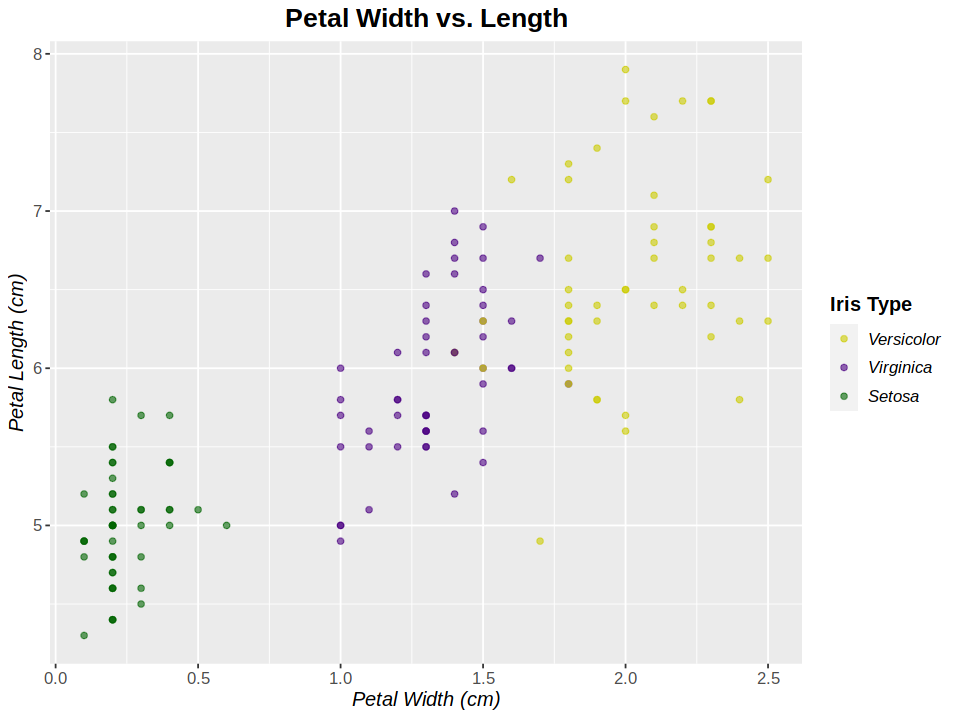

In [6]:
petal_width_vs_length

##### <font color="#4B0082"> Figure 1. Petal width vs. Petal length

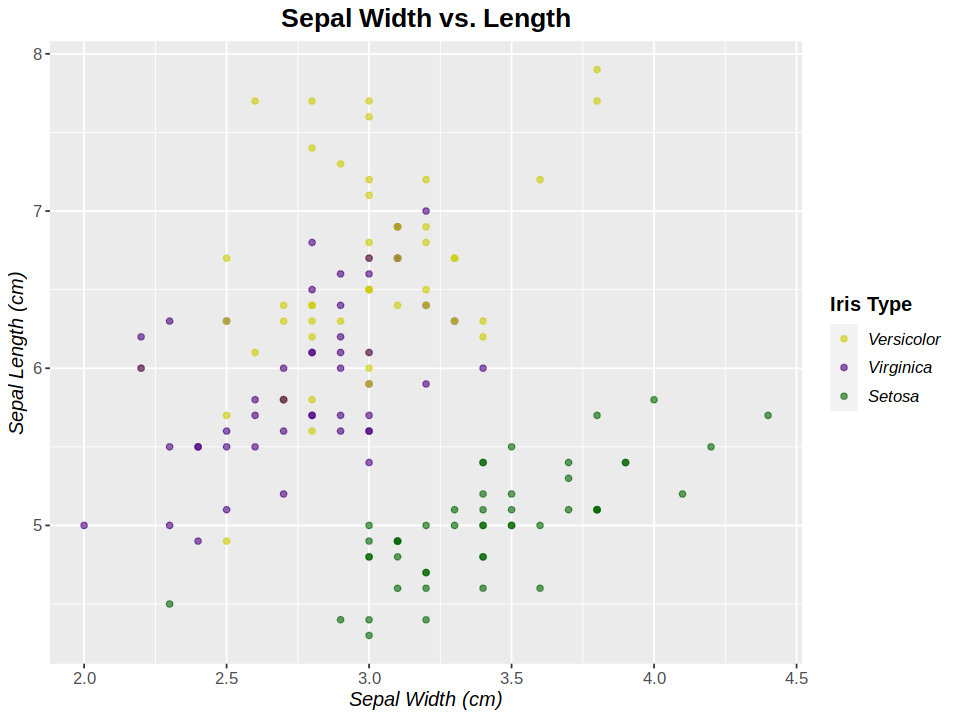

In [7]:
sepal_width_vs_length

##### <font color="#4B0082"> Figure 2. Sepal width vs. length

After conducting a visual exploration of the relationship between petal and sepal measurements in our dataset, we created scatterplots to compare petal width vs. petal length and sepal width vs. sepal length. These visualizations revealed patterns where points from the same species tended to cluster together in different regions of the plots. This suggested a potential relationship between petal and sepal measurements with the classification of *Iris* species.

Upon initial inspection, the graph of petal width vs length contains clear groups based on species. *Setosa* seems to have a smaller petal length and width than the other types. *Virginica* typically is in the middle of *Setosa* and *Versicolor* for petal width and length and *Versicolor* typically has the greatest width and length measurements. 

However, the sepal width vs. length graph does not show this same pattern. *Setosa* has clear grouping whereas *Versicolor* and *Virginica* have many more overlapping points. *Setosa* seems to typically have shorter sepal length and greater sepal width for the most part. *Virginica* and *Versicolor* overlap quite a bit but the largest sepal length values are associated with the species *Virginica*. 

To use this observed pattern, we decided to train two distinct prediction models. One model will focus on using petal length and width as predictors, while the other model will use sepal length and width as predictors. Using two different models allows us to investigate the contributions of both petal and sepal measurements independently in predicting the species, providing insights into which set of features plays a more significant role in classification.   

Based on the above graphs, we predict that the petal classification model will have a higher accuracy for species than the sepal classification model. We will create, train and test both a petal classification model and a sepal classification model. We will then compare the accuracy of the two models to test our hypothesis that the petal classification model will predict *Iris* species with greater accuracy than the sepal classification model.

To determine an optimal value for `k` in our `kknn` classification models, we will perform cross-validation. This process helps ensure that our models generalize well to new, unseen data. Once we have identified the best k-values, we will train our models on both sets of features using that k-value and evaluate their accuracy.

By comparing the accuracy of the two models, we aim to quantify the relative importance of sepal measurements versus petal measurements in determining species classifications of *Virginica*, *Setosa*, and *Versicolor*. This approach allows us to gain an understanding of the predictive power of each set of measurements.

#### Classification:
First we divide our data into training and testing sets. We will train our models on the training set first.

In [9]:
# Split data
pre_split_iris <- iris_clean
iris_split <- initial_split(pre_split_iris, prop = 0.7, strata = class, shuffle = TRUE)

# Shuffle the split using slice_sample
iris_train <- training(iris_split)
iris_test <- testing(iris_split)

In [10]:
iris_train

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
5.5,3.5,1.3,0.2,setosa
4.4,3.2,1.3,0.2,setosa
5.4,3.7,1.5,0.2,setosa
⋮,⋮,⋮,⋮,⋮
5.8,2.8,5.1,2.4,virginica
6.3,2.7,4.9,1.8,virginica
6.7,3.1,5.6,2.4,virginica


##### <font color="#4B0082"> Table 3. Training set of Iris dataset

In [11]:
iris_test

sepal_length,sepal_width,petal_length,petal_width,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6.4,2.8,5.6,2.2,virginica
7.7,2.8,6.7,2.0,virginica
5.7,2.8,4.5,1.3,versicolor
⋮,⋮,⋮,⋮,⋮
5.4,3.0,4.5,1.5,versicolor
6.3,2.8,5.1,1.5,virginica
7.9,3.8,6.4,2.0,virginica


##### <font color="#4B0082"> Table 4. Testing set of Iris dataset

#### Now, We start creating our models, training them, and obtaining their accuracies.
### Petal KNN Classification:
#### Predictors: 
    * Petal Width
    * Petal Length

### 1. First we perform cross-validation to obtain the best K value to use
##### 1.1. Select the desired columns from `iris_train` and `iris_test`

In [12]:
#1.1
iris_train_petal <- iris_train |>
    select(class, petal_width, petal_length)
nrow(iris_train_petal)

iris_test_petal <- iris_test |>
    select(class, petal_width, petal_length)
nrow(iris_test_petal)

[1] 104

[1] 45

In [15]:
head(iris_train_petal)

class,petal_width,petal_length
<fct>,<dbl>,<dbl>
setosa,0.2,1.3
setosa,0.2,1.3
setosa,0.2,1.5
setosa,0.2,1.6
setosa,0.2,1.5
setosa,0.4,1.6


##### <font color="#4B0082"> Table 5. Petal Training Set

In [14]:
head(iris_test_petal)

class,petal_width,petal_length
<fct>,<dbl>,<dbl>
virginica,2.2,5.6
virginica,2.0,6.7
versicolor,1.3,4.5
versicolor,1.2,4.4
setosa,0.2,1.3
setosa,0.4,1.7


##### <font color="#4B0082"> Table 6. Petal Testing Set

##### 1.2. Split the `iris_train_petal` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [17]:
#1.2
petal_vfold <- vfold_cv(iris_train_petal, 
                        strata= class, v = 5)

#1.3
petal_recipe <- recipe(class ~ . , 
                       data= iris_train_petal)
petal_recipe

#1.4
petal_spec <- nearest_neighbor(weight_func = "rectangular", 
                               neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
petal_spec

#1.5
petal_workflow <- workflow() |>
    add_recipe (petal_recipe)|>
    add_model (petal_spec)
petal_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


##### 1.6. Create a `tibble` called `k_vals` to determine the range and intervals of K we want to perform the cross-validation on.
##### 1.7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, and collected and filtered the `accuracy` to obtain the `accuracies` of our K.
##### 1.8. Plotted `accuracy` vs. `K` to visualize what would be the best K with the highest accuracy estimate.

In [24]:
options(repr.plot.height = 6, repr.plot.width = 12)
#1.6
k_vals_petal <- tibble(neighbors = seq(1,77, by=2))

#1.7
accuracies_petal <- petal_workflow |>
    tune_grid(resamples = petal_vfold, 
              grid = k_vals_petal) |>
    collect_metrics() |>
filter(.metric == "accuracy")
#1.8
cross_val_plot_petal <- accuracies_petal |>
    ggplot(aes(x = neighbors, 
               y = mean)) +
    geom_point(color = "#FF00FF") +
    geom_line(color = "#006400") +
    labs(x = "k (Number of Neighbors)",
         y = "Petal Measurements' Accuracy",
         title = "K vs. Accuracy") +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks = seq(1, 77, by = 2)) # adjusting the x-axis

In [25]:
head(accuracies_petal)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.9514286,5,0.03050594,Preprocessor1_Model01
3,accuracy,multiclass,0.9514286,5,0.02184256,Preprocessor1_Model02
5,accuracy,multiclass,0.9609524,5,0.01858973,Preprocessor1_Model03
7,accuracy,multiclass,0.9514286,5,0.02184256,Preprocessor1_Model04
9,accuracy,multiclass,0.9609524,5,0.01858973,Preprocessor1_Model05
11,accuracy,multiclass,0.9514286,5,0.02184256,Preprocessor1_Model06


##### <font color="#4B0082"> Table 7. Petal Model Accuracy of training set

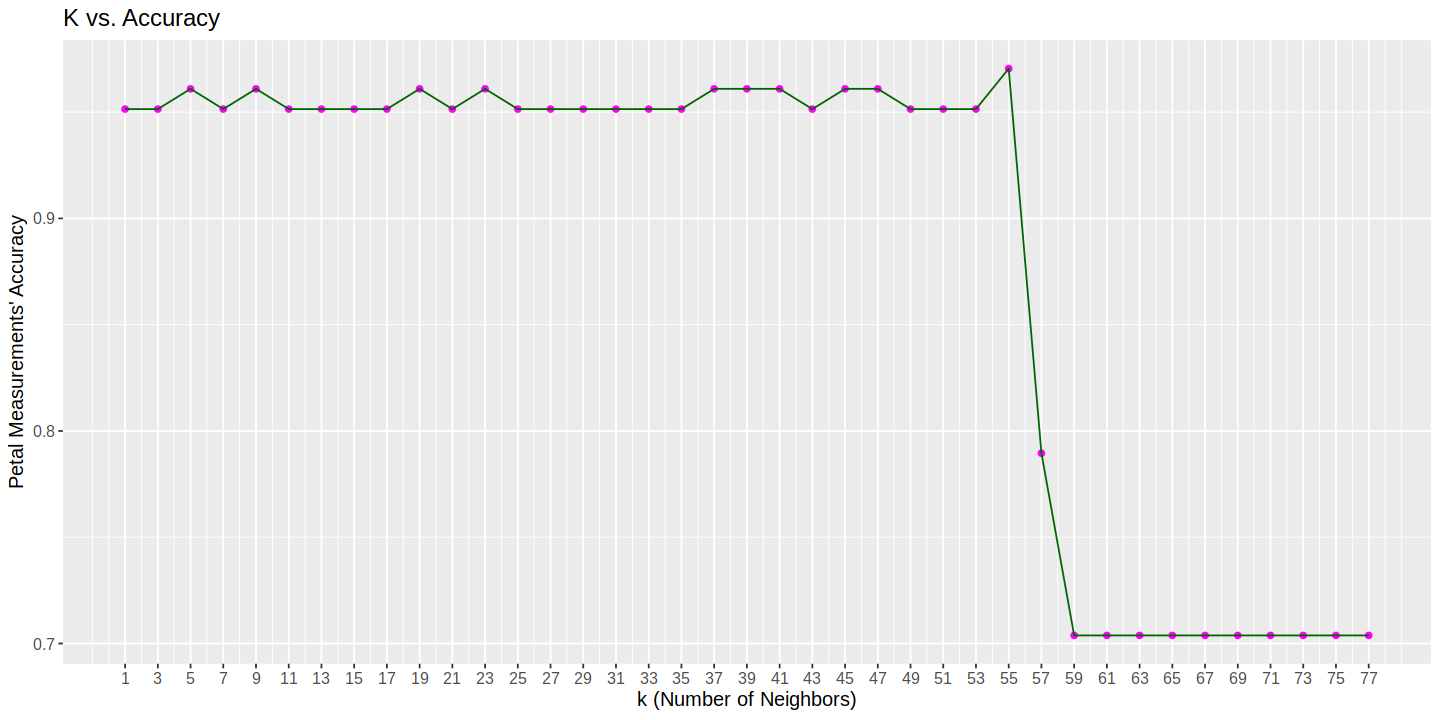

In [26]:
cross_val_plot_petal

##### <font color="#4B0082"> Figure 3. Number of K vs. Petal Measurements' Accuracy 

##### 1.9 For each model, we started by looking at lower K’s and kept increasing until there was a clear decline in accuracy. For the Petal Model, there was a drastic decline after K = 55 therefore giving us a K = 35 as the best fitted K value for the Petal Model Classification.  As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=35

### 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 35` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`petal_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `iris_test_petal`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `Sepal` model.

In [27]:
#2.1 
petal_final_spec <- nearest_neighbor(weight_func = "rectangular", 
                                     neighbors = 35)|>
    set_engine("kknn") |>
    set_mode("classification")

#2.2
petal_final_workflow <- workflow() |>
    add_recipe(petal_recipe)|>
    add_model(petal_final_spec)|>
    fit(data = iris_train_petal)
petal_final_workflow

2.3
petal_prediction <- predict(petal_final_workflow, iris_test_petal)|>
    bind_cols(iris_test_petal)

2.4
petal_accuracy <- petal_prediction |>
    metrics(truth = class, 
            estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(35,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.04807692
Best kernel: rectangular
Best k: 35

[1] 2.3

[1] 2.4

In [28]:
head(petal_prediction)

.pred_class,class,petal_width,petal_length
<fct>,<fct>,<dbl>,<dbl>
virginica,virginica,2.2,5.6
virginica,virginica,2.0,6.7
versicolor,versicolor,1.3,4.5
versicolor,versicolor,1.2,4.4
setosa,setosa,0.2,1.3
setosa,setosa,0.4,1.7


##### <font color="#4B0082"> Table 8. Petal Model Prediction results table

In [29]:
head(petal_accuracy)

.estimate
<dbl>
0.9777778


##### <font color="#4B0082"> Table 9. Petal Model Prediction Accuracy results

#### The Petal KNN Classification model's Accuracy = 0.9777778

### Sepal KNN Classification:
#### Predictors: 
    * Sepal Width
    * Sepal Length

### 1. First we perform cross-validation to obtain the best K
##### 1.1. Select the desired columns from `iris_train` and `iris_test`

In [30]:
#1.1
iris_train_sepal <- iris_train |>
    select(class, sepal_width, sepal_length)
nrow(iris_train_sepal)

iris_test_sepal <- iris_test |>
    select(class, sepal_width, sepal_length)
nrow(iris_test_sepal)

[1] 104

[1] 45

In [32]:
head(iris_train_sepal)

class,sepal_width,sepal_length
<fct>,<dbl>,<dbl>
setosa,3.5,5.5
setosa,3.2,4.4
setosa,3.7,5.4
setosa,3.0,5.0
setosa,3.1,4.6
setosa,3.4,5.0


##### <font color="#4B0082"> Table 10. Sepal Model Training Set

In [33]:
head(iris_test_sepal)

class,sepal_width,sepal_length
<fct>,<dbl>,<dbl>
virginica,2.8,6.4
virginica,2.8,7.7
versicolor,2.8,5.7
versicolor,2.6,5.5
setosa,3.2,4.7
setosa,3.9,5.4


##### <font color="#4B0082"> Table 11. Sepal Model Testing Set

##### 1.2. Split the `iris_train_sepal` for cross-validation through `vfold_cv`.
##### 1.3. Create the `recipe`, include the correct `predictors` and `pre-process` the data.
##### 1.4. Create the `knn` `model`, using the appropriate engine and mode and set `neighbors = tune()`.
##### 1.5. Fit the `recipe` and `model` into the `workflow`.

In [34]:
#1.2
sepal_vfold <- vfold_cv(iris_train_sepal, 
                        strata = class, v = 5)

#1.3
sepal_recipe <- recipe(class ~ ., data = iris_train_sepal)
sepal_recipe

#1.4
sepal_spec <- nearest_neighbor(weight_func = "rectangular", 
                               neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")
sepal_spec

#1.5
sepal_workflow <- workflow() |>
    add_recipe(sepal_recipe) |>
    add_model(sepal_spec)
sepal_workflow

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


##### 1.6. Made a `tibble` called `k_vals` to determine the range and intervals of $K$s we want to perform the cross-validation on.
##### 1.7. Used the `tune_grid` function on our train/validation splits to estimate the classifier accuracy for a range of K values, collected and filtered the `accuracy` to obtain the `accuracies` of our $K$s.
##### 1.8. Plotted `accuracy` vs. `K` to visualize what would be the best $K$ with the highest accuracy estimate that doesn’t change much if you change K to a nearby value.

In [36]:
options(repr.plot.height = 6, repr.plot.width = 12)
#1.6
k_vals_sepal <- tibble(neighbors = seq(1,78, by = 2))

#1.7
accuracies_sepal <- sepal_workflow |>
    tune_grid(resamples = sepal_vfold, grid = k_vals_sepal) |>
    collect_metrics() |>
    filter(.metric == "accuracy")
#1.8
cross_val_plot_sepal <- accuracies_sepal |>
    ggplot(aes(x = neighbors, 
               y = mean)) +
    geom_point(color = "#FF00FF") +
    geom_line(color = "#006400") +
    labs (x = "k (Number of Neighbors)",
          y = "Sepal Measurements' Accuracy",
          title = "K vs. Accuracy") +
    theme(text = element_text(size = 12))+
    scale_x_continuous(breaks = seq(1, 78, by = 2))# adjusting the x-axis

In [37]:
head(accuracies_sepal)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6733333,5,0.04311036,Preprocessor1_Model01
3,accuracy,multiclass,0.6928571,5,0.03458533,Preprocessor1_Model02
5,accuracy,multiclass,0.7214286,5,0.02704242,Preprocessor1_Model03
7,accuracy,multiclass,0.7504762,5,0.02221315,Preprocessor1_Model04
9,accuracy,multiclass,0.7400000,5,0.02029264,Preprocessor1_Model05
11,accuracy,multiclass,0.7495238,5,0.01949475,Preprocessor1_Model06


##### <font color="#4B0082"> Table 12. Sepal Model Accuracy of training set

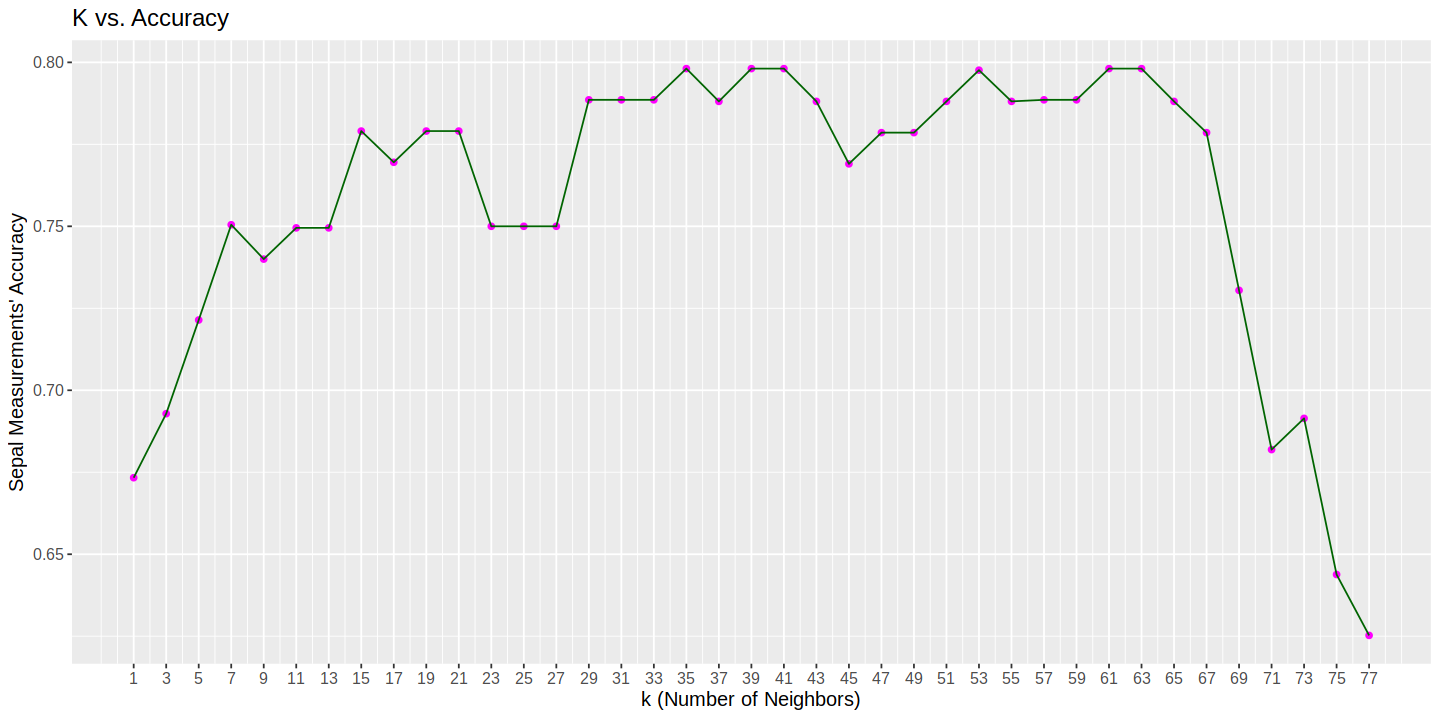

In [38]:
cross_val_plot_sepal

##### <font color="#4B0082"> Figure 4. Number of K vs. Sepal Measurements' Accuracy 

In [27]:
x_values <- c(17, 35, 41, 43, 55)
y_coordinates <- accuracies_sepal |>
    filter(neighbors %in% x_values) |>
    select(neighbors, mean) |>
    filter(mean == max(mean))

In [28]:
y_coordinates

neighbors,mean
<dbl>,<dbl>
17,0.787619
41,0.787619
43,0.787619


##### <font color="#4B0082"> Table 13. Obtaining the maximum K from the seen 5 top peaks

##### 1.9 For each model, we started by looking at lower K’s and kept increasing until there was a clear decline in accuracy. For the Sepal K values, there was some increase until K = 43 after which there was a continuous decline. Therefore, this gives us a K = 43 as the best-fitted K value for the Sepal Model Classification. As shown in the `K`Vs.`accuracy` plot, the best $K$ is $K$=43 

### 2. Now that we have obtained our best `K`, we will perform `knn` on our training data with this value of `k`
##### 2.1. Create a new `knn` `model`, using the appropriate engine and mode and set `neighbors = 17` as we obtained in the cross-validation.
##### 2.2. Fit the `recipe` we made previously called`sepal_recipe`and new `model` into the `workflow`.
##### 2.3. Use the function `predict` to apply the prediction on our testing data `iris_test_sepal`.
##### 2.4. Finally we report the accuracy of this prediction and will store this number to compare to accuracy of our `Petal` model.

In [39]:
#2.1 
sepal_final_spec <- nearest_neighbor(weight_func = "rectangular", 
                                     neighbors = 43)|>
    set_engine("kknn") |>
    set_mode("classification")

#2.2
sepal_final_workflow <- workflow() |>
    add_recipe(sepal_recipe)|>
    add_model(sepal_final_spec)|>
    fit(data = iris_train_sepal)
sepal_final_workflow

2.3
sepal_prediction <- predict(sepal_final_workflow, iris_test_sepal)|>
    bind_cols(iris_test_sepal)

2.4
sepal_accuracy <- sepal_prediction |>
    metrics(truth = class, 
            estimate = .pred_class) |>
    filter(.metric == "accuracy")|>
    select(.estimate)

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(43,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2307692
Best kernel: rectangular
Best k: 43

[1] 2.3

[1] 2.4

In [40]:
head(sepal_prediction)

.pred_class,class,sepal_width,sepal_length
<fct>,<fct>,<dbl>,<dbl>
versicolor,virginica,2.8,6.4
virginica,virginica,2.8,7.7
versicolor,versicolor,2.8,5.7
versicolor,versicolor,2.6,5.5
setosa,setosa,3.2,4.7
setosa,setosa,3.9,5.4


##### <font color="#4B0082"> Table 13. Sepal Model Prediction results table

In [41]:
head(sepal_accuracy)

.estimate
<dbl>
0.7777778


##### <font color="#4B0082"> Table 14. Sepal Model Prediction Accuracy results

#### The Sepal KNN Classification model's Accuracy = 0.7777778

### Determine the best predictor set
#### Now that have done the classification of both prediction factors of petal and sepal models, we will compare their accuracies:

In [43]:
options(repr.plot.height = 6, repr.plot.width = 6)
iris_colors <- c("Sepal" = "#006400", "Petal" = "#4B0082" )

#Create a tibble of accuracies of 2 models
accuracies_comparison <- tibble(model = c("Petal", "Sepal"),
                                accuracy = c(petal_accuracy, sepal_accuracy))

#visualize the comparison of 2 model's accuracies
model_comparison_plot <- accuracies_comparison |>
    ggplot(aes(x = model, 
               y = as.numeric(accuracy) * 100, 
               fill = model)) +
    geom_bar(stat = "identity") +
    labs (x = "Model", 
          y = "Accuracy (%)", 
          fill = "Model") +
    ggtitle("Accuracy comparison of Petal vs. Sepal") +
    scale_fill_manual(values = iris_colors)

In [44]:
accuracies_comparison

model,accuracy
<chr>,<named list>
Petal,0.9777778
Sepal,0.7777778


##### <font color="#4B0082"> Table 15. Petal model and Sepal model Accuracy results

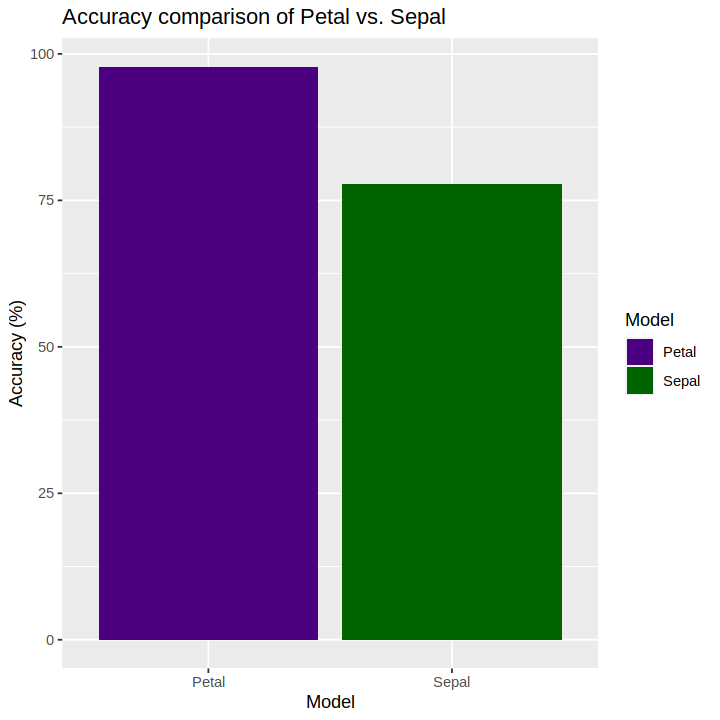

In [45]:
model_comparison_plot

##### <font color="#4B0082"> Figure 5. Petal model vs. Sepal model accuracies' comparison 

The bar plot of the comparison of the 2 predicting groups shows that although there is a difference of 0.2 between the accuracies, the difference is so small that it can be negligible when predicting the species of *Iris*. However, the petal model is slightly more accurate and looking at length and width of the petal can be more beneficial for predicting species.

### Discussion:
From our K-nearest neighbors classification test, we found that petal width and length are better predictors for species in *Iris* flowers than sepal width and length. This is consistent with our earlier hypothesis. Based on the correlations found in the two scatter plots of our initial visualization of the data, we expected to find the model created from petal measurements to be a more accurate predictor of *Iris* plant type than the model created from sepal measurements. We multiplied the accuracy of each model by 100 to get a percentage for each. The accuracy of the prediction based on petal measurements significantly drops at K = 55. We find that the accuracy of petals as a predictor is 96%. However, the accuracy of sepals as a predictor is 80%.

Scientists can understand the most accurate way to classify Iris species. Although 

These findings could lead to numerous future questions including:
* If the petal model is better than the sepal model, perhaps petal measurements are better predictors of classifications of other plants in different families. 
* Maybe Iris petals could be used to distinguish and predict classification types of plants within the iris family 


### Refrrences: ....
* https://archive.ics.uci.edu/dataset/53/iris